In [7]:
using Aeroelasticity, GXBeam, DifferentialEquations, LinearAlgebra

# discretization
N = 8 # number of elements

# geometric properties
span = 6.096 # m (20 ft span)
chord = 1.8288 # m (6 ft chord)

# structural section properties
xea = 0.33*chord # m (elastic axis, from leading edge)
EIcc = 9.77e6 # N*m^2 (flat bending rigidity)
GJ = 0.99e6 # N*m^2 (torsional rigidity)
μ = 35.71 # kg/m (mass per unit length)
xcm = 0.43*chord # m (center of mass, from leading edge)
i11 = 8.64 # kg*m (moment of inertia about elastic axis)
i22 = 0.1*i11 # moment of inertia about beam y-axis
i33 = 0.9*i11 # moment of inertia about beam z-axis

# freestream properties
Vinf = vcat(1, 5:5:200) # m/s (velocity)
α = 0 # angle of attack

# aerodynamic section properties
xref = xea/chord # normalized reference location (relative to leading edge)
a = xref - 0.5 # normalized reference location (relative to semi-chord)
b = chord / 2 # m (semi-chord)
ρ = 1.02 # kg/m^3 (air density)
a0 = 0.85*(2*pi) # lift slope (for each section)
α0 = 0 # zero lift angle of attack (for each section)
cd0 = 0
cm0 = 0

# define geometry
xpt = range(0, 0, length=N+1) # point x-coordinates (in body frame)
ypt = range(0, span, length=N+1) # point y-coordinates (in body frame)
zpt = range(0, 0, length=N+1) # point z-coordinates (in body frame)
points = [[xpt[i],ypt[i],zpt[i]] for i = 1:N+1]
start = 1:N # starting point of each beam element
stop = 2:N+1 # ending point of each beam element
frames = fill([0 1 0; 1 0 0; 0 0 -1], N) # local to body frame transformation
compliance = fill(Diagonal([0, 0, 0, 1/GJ, 1/EIcc, 0]), N) # compliance matrix
xm2 = xea - xcm
mass = fill([
    μ 0 0 0 0 -μ*xm2;
    0 μ 0 0 0 0;
    0 0 μ μ*xm2 0 0;
    0 0 μ*xm2 i11 0 0;
    0 0 0 0 i22 0;
    -μ*xm2 0 0 0 0 i33], N) # mass matrix
assembly = GXBeam.Assembly(points, start, stop; frames, compliance, mass)

prescribed = Dict(
    # fixed left edge
    1 => GXBeam.PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
        theta_z=0),
)

# prescribed point conditions
point_conditions = zeros(6, length(assembly.points))

# additional distributed loads
element_loads = zeros(6, length(assembly.elements))

# construct aerodynamic model
aerodynamic_model = LiftingLine{N}(Peters{6}())

# construct structural model
structural_model = GEBT(assembly, prescribed)

# define coupled model
model = couple_models(aerodynamic_model, structural_model)

# construct ODE function
f = get_ode(model)

# current time
t = 0.0

# eigenvalue/eigenvector storage
nev = 12*N
λ = zeros(ComplexF64, nev, length(Vinf))
Uλ = zeros(ComplexF64, nev, number_of_states(model), length(Vinf))
Vλ = zeros(ComplexF64, number_of_states(model), nev, length(Vinf))

# initial guess for state variables
x0 = zeros(number_of_states(model))

# loop through each velocity
for i = 1:length(Vinf)

    println(Vinf[i])

    # set parameters
    p_aero = get_parameters(aerodynamic_model; section_parameters =
        fill((a=a, b=b, a0=a0, alpha0=α0, cd0=cd0, cm0=cm0), N))

    p_stru = get_parameters(structural_model; assembly = assembly)

    p_additional = get_additional_parameters(model;
        rho = ρ,
        point_conditions = point_conditions,
        element_loads = element_loads,
        u = Vinf[i],
        v = 0,
        w = 0,
        p = 0,
        q = 0,
        r = 0,
        )

    p = vcat(p_aero, p_stru, p_additional)

    # find state variables corresponding to steady state operating conditions
    sol = solve(SteadyStateProblem(f, x0, p), SSRootfind())

    # use state variables from steady state operating conditions
    x = sol.u

    # linearize about steady state operating conditions
    K, M = linearize(model, x, p)

    # perform linear stability analysis
    λi, Uλi, Vλi = get_eigen(model, K, M; nev)

    # correlate eigenvalues
    if i > 1
        # previous left eigenvector matrix
        Uλpi = Uλ[:,:,i-1]

        # use correlation matrix to correlate eigenmodes
        perm, corruption = Aeroelasticity.correlate_eigenmodes(Uλpi, M, Vλi)

        # re-arrange eigenmodes
        λi = λi[perm]
        Uλi = Uλi[perm,:]
        Vλi = Vλi[:,perm]
    end

    # save eigenvalues/eigenvectors
    λ[:,i] = λi
    Uλ[:,:,i] = Uλi
    Vλ[:,:,i] = Vλi

    # update initial guess for the state variables
    x0 .= x
end

1
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200


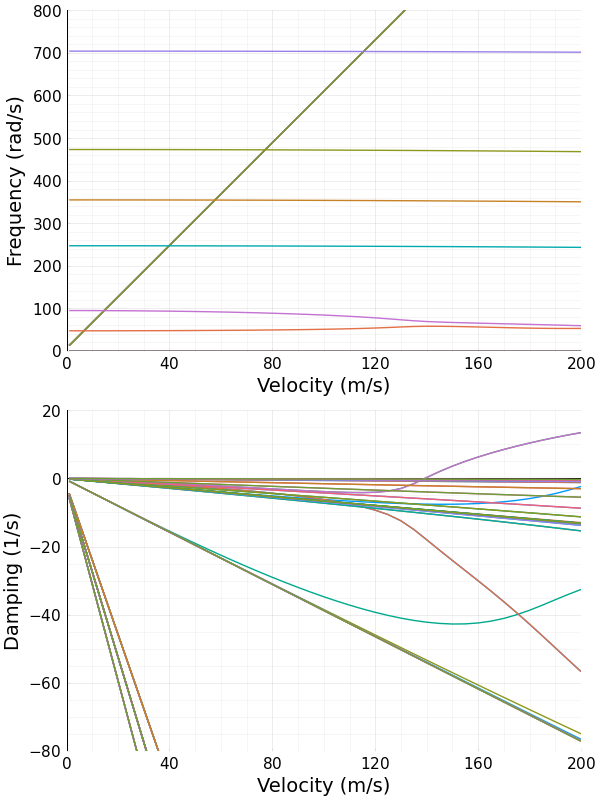

In [8]:
using Plots
pyplot()

sp1 = plot(
    xlim = (0, 200),
    xtick = 0:40:200,
    xlabel = "Velocity (m/s)",
    ylim = (0, 800),
    ytick = 0:100:800,
    ylabel = "Frequency (rad/s)",
    framestyle = :zerolines,
    titlefontsize = 14,
    guidefontsize = 14,
    legendfontsize = 11,
    tickfontsize = 11,
    legend = :topright,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=true)

sp2 = plot(
    xlim = (0, 200),
    xtick = 0:40:200,
    xlabel = "Velocity (m/s)",
    ylim = (-80, 20),
    ytick = -80:20:20,
    ylabel = "Damping (1/s)",
    framestyle = :zerolines,
    titlefontsize = 14,
    guidefontsize = 14,
    legendfontsize = 11,
    tickfontsize = 11,
    legend = :topright,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=true)

for i = 1:size(λ, 1)

    Vi = Vinf[:]
    λi = λ[i,:]

    if any(-80 .<= real.(λi) .<= 20)
        plot!(sp1, Vi, imag.(λi),
            label = "",
            color = i,
            markersize = 3,
            markerstrokewidth = 0,
            )
    end

end

for i = 1:size(λ, 1)

    Vi = Vinf[:]
    λi = λ[i,:]

    if any(-80 .<= real.(λi) .<= 20)
        plot!(sp2, Vi,
            real.(λi),
            label = "",
            color = i,
            markersize = 3,
            markerstrokewidth = 0,
            )
    end
end

p1 = plot(sp1, sp2, layout = (2, 1), size = (600, 800), show=true)